# Test Sequences Lab Book

## Objective: Document process of creating 1st batch of test sequences

## Rik Khot
## Cardiff University School of Physics & Astronomy
## Supervisors: Kevin Murphy, Ian Driver, Emre Kopanoglu
## May 2025 

# Introduction


## Aims

I will create a batch of test sequences to trial on the Siemens 3T PRISMA. These are the following aims of these tests:

- To learn how to navigate loading pulseq files onto a Siemens MR Scanner
- To investigate alternative open-source pulse sequences for DIMAC (as opposed to Siemens pre-made sequences)
- To gather information on product specifications for 3T PRISMA (so these can be hard coded into pulseq files)
- To incorporate existing image reconstruction techniques (SENSE/GRAPPA) within pulseq scripts

## The Test Sequence list (subject to change)

- EPI
- EPI (with spoiled gradients)
- Radial
- Golden angle Radial
- Spiral

- EPI Undersampled
- Radial Undersampled
- Spiral Undersampled

### An Aside: Filing Convention

Files will be saved with the following naming convention:

**SEQTYPE_TRVal_Undersampled.py**

e.g.1. EPI_14ms.py for EPI that is **not undersampled**
e.g.2. EPI_14ms_U.py for EPI that is **undersampled**

## DIMAC Criteria
Dynamic Inflow MAgnitude Contrast (DIMAC) requires an ultra-fast TR. We require $TR \le 15ms$

DIMAC measure real-time pulsatile flow into a slice. The aim is to "dull down" all other signals, so that fresh signals entering a slice have a high signal intensity w.r.t the rest of the slice componants.

The main advantage of DIMAC is that is does not require Motion Encoding Gradients and uses the natural phenomena of the inflow effect to observe new flow entering a slice across an artery.

Therefore we define the following criteria:

- $TR \le 15ms$
- Pulse sequence supresses all signal within slice (so that new signals are clearly observed)
- Single Slice
- Single shot?

## 3T Siemens PRISMA Specifications


### Reasoning for acquiring information
Within Pulseq code we have a section of code defining system limits:

In [1]:
import pypulseq as pp
# Set system limits
system = pp.Opts(
    max_grad=32,
    grad_unit='mT/m',
    max_slew=130,
    slew_unit='T/m/s',
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    )

However as of writing (23/05/25) we do not know if this matches the Siemens 3T PRISMA specifications. So let's find out.

### The Specifications
*Source: [Siemens Healthineers Website](https://www.siemens-healthineers.com/magnetic-resonance-imaging/3t-mri-scanner/magnetom-prisma)*
- Maximum Gradient Amplitude = **139 mT/m**
- Maximum Slew Rate = **346 T/m/s**
- RF Ringdown Time = **?**
- RF Dead Time = **?**
- FOV = **0.125 m^3**

**Note: Pulseq update now means FOV is read in meters**

## Simulations with Koma MRI

Koma MRI is a package written in Julia, which simulates the resultant K-space data and image reconstruction from a given pulseq file. 

**Note: Koma MRI simulations shown in this document do NOT consider inflow effect**

In future, we will need to consider adding inflow effects to our Koma MRI simulations, for a better prediction of MR reconstruction images for test pulse sequences.

# EPI

Here we will explore the simplest EPI file on pypulseq. Original file is **write_epi.py**. I have made edits in line with the DIMAC and Siemens 3T PRISMA criteria, on a new file named **write_epi_rk.py** (a file where I can play around with parameters) which can be found on my private Git branch.

Here I will change parameters to shorten TR as much as possible **without undersampling**.


## EPI, TR = 14ms

*Variable change: Nx and Ny = 32*

Hypothesis: because of the extremely small matrix size, I expect the image to have many artefacts

FILENAME: epi_14ms.py
    
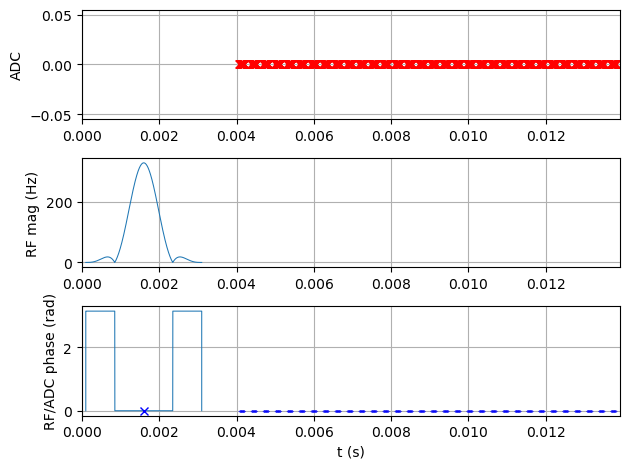
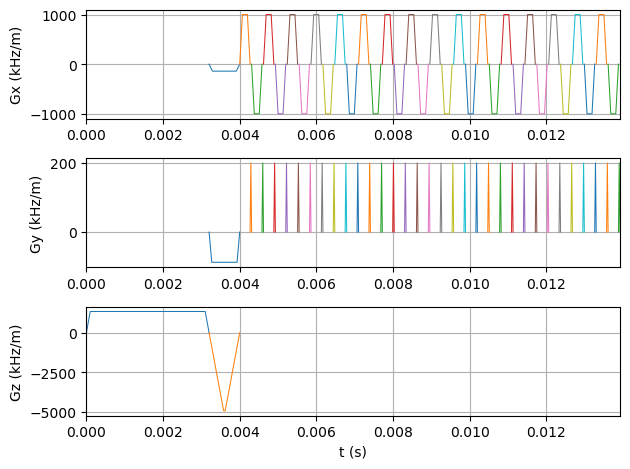



### Results 

#### KomaMRI (Simulated results)


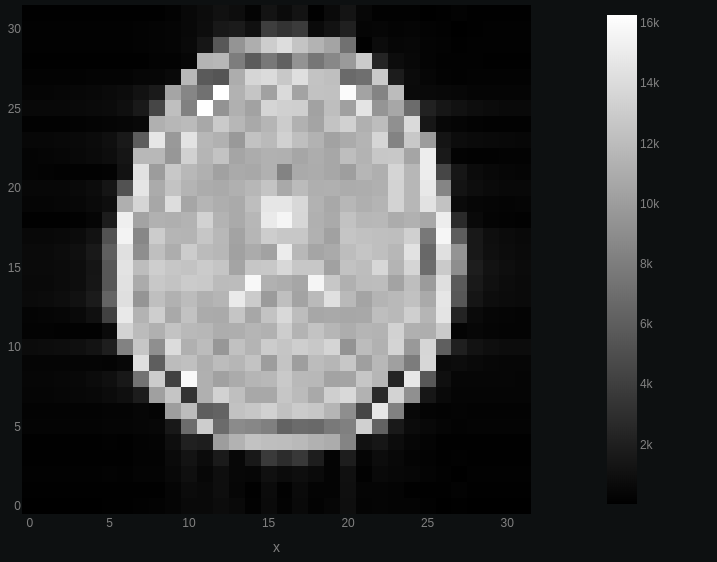

As you can see the reduced Matrix size has lowered the image quality, as the slice is of a very low resolution.

#### 3T MRI Result




## EPI, TR = 32ms

*Variable change: Nx and Ny = 64*

Hypothesis: Image quality will be fair, however for blood pulsatility the TR is way too long => not useful for DIMAC?

FILENAME: epi_32ms.py

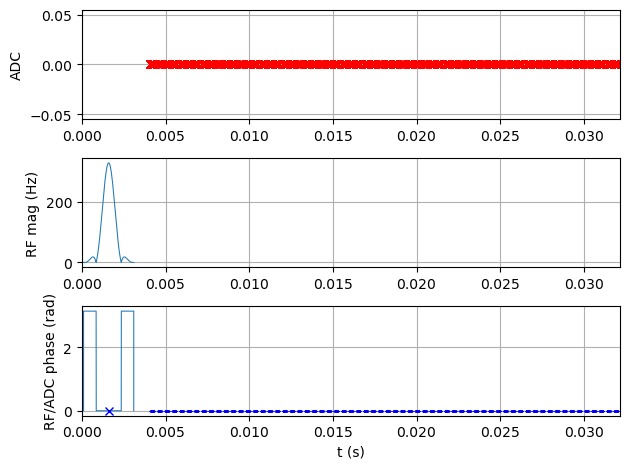
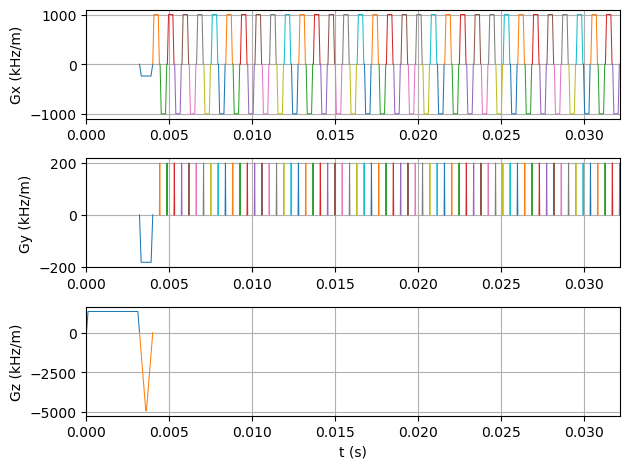

### Results 

#### KomaMRI (Simulated Results)

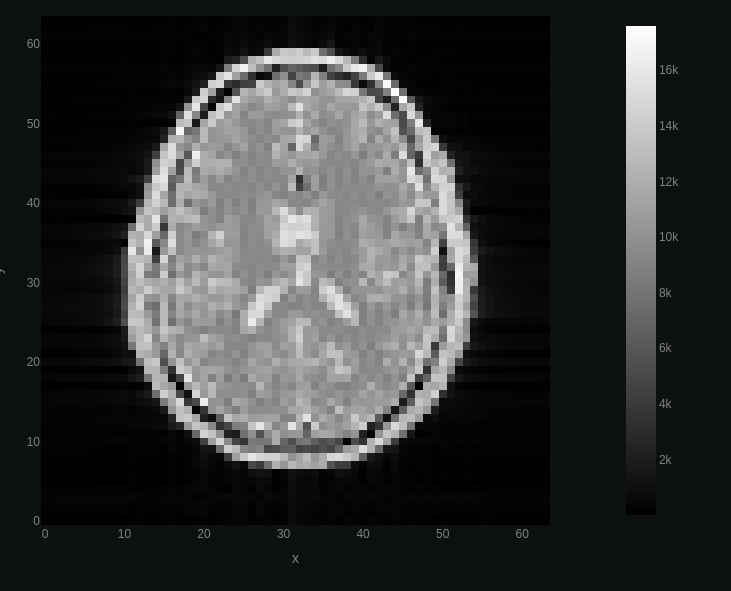

As you can see by having a matrix size of 64 the image resolution has improved, however at the cost of a longer TR, meaning the inflow "pulse" will likely be affected by the RF pulse causing loss of T1 magnetisation.

#### MRI Results




# EPI (Spoiled Gradients)
Here we will explore the spoiled gradients EPI file on pypulseq. Original file is **write_epi_se.py**. I have made edits in line with the DIMAC and Siemens 3T PRISMA criteria, on a new file named **write_epi_se_rk.py** which can be found on my private Git branch.

Here I will change parameters to shorten TR as much as possible **without undersampling**.

## EPI Spoiled, TR = 46ms

Variable changes:
- Nx, Ny = 32
- TE = $37e-4$
- pre-time = $5e-4$
- RF 180 pulse duration = $100e-6$
- RF dead time = $100e-5$

Hypothesis: Image quality will be bad

Note: Found it very difficult to decrease TR significantly

FILENAME: epi_se_46ms.py

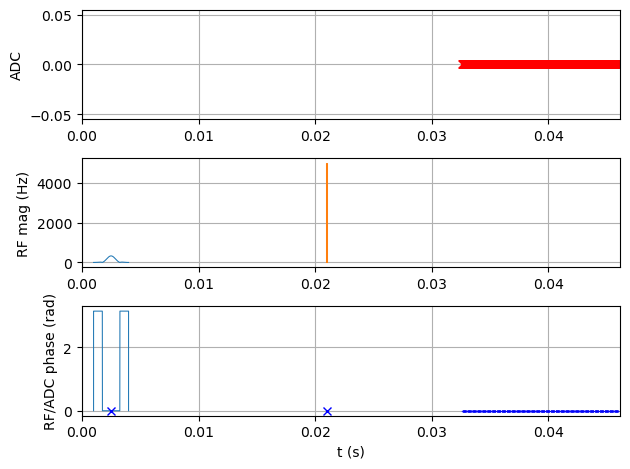
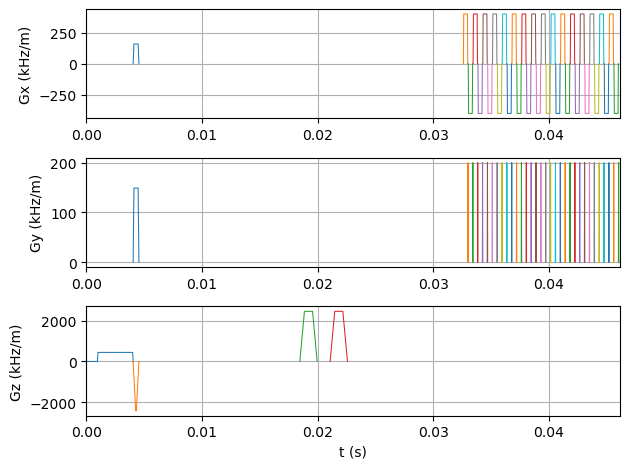


### Results 

#### KomaMRI (Simulated results)

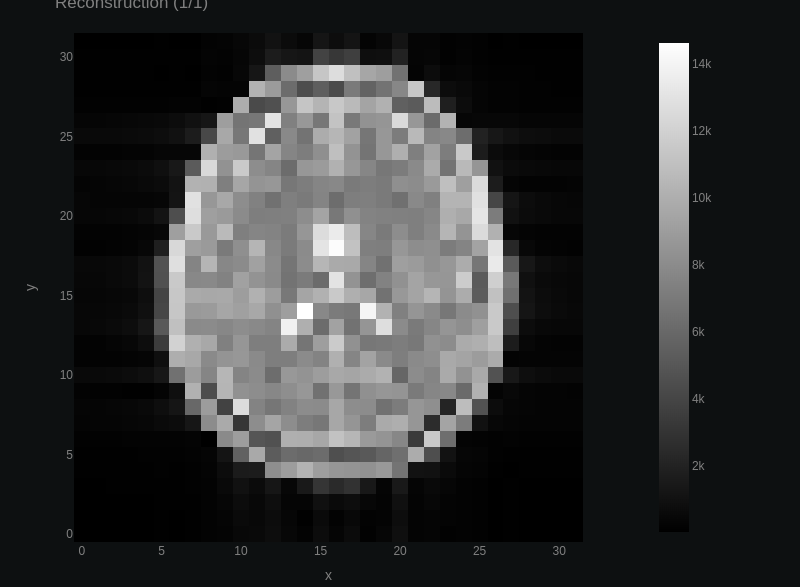

Here the matrix size is very small (N=32) and that hugely affects the image resolution.


#### 3T MRI Result



# Radial

Here we will explore the simplest Gradient Recalled Echo Radial file on pypulseq. Original file is **write_radial_gre.py**. I have made edits in line with the DIMAC and Siemens 3T PRISMA criteria, on a new file named **write_radial_gre_rk.py**( a file where I can play around with parameters) which can be found on my private Git branch.

Here I will change parameters to shorten TR as much as possible **without undersampling**.

## Radial, Total Time = 44ms

Variable changes:

- Flip Angle, Alpha = 90
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- Nr = 4
- N_dummy = 0

Nr, N_dummy and TR seemed to reduce the Total scan time dramatically.

I expect the image to be sparse due to there being only 4 radial spokes.

FILENAME: gre_radial_44ms.py

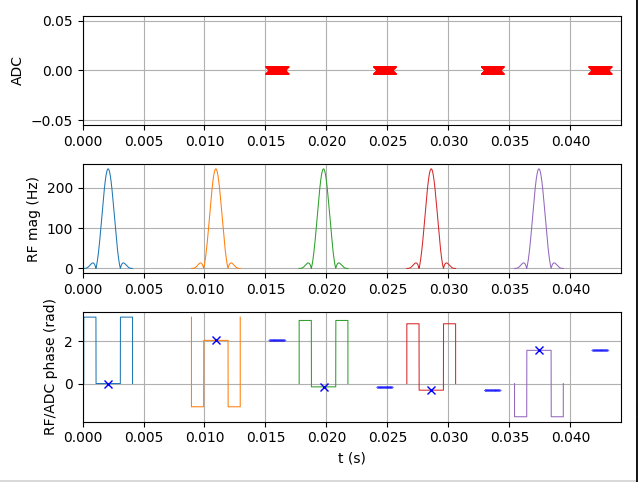
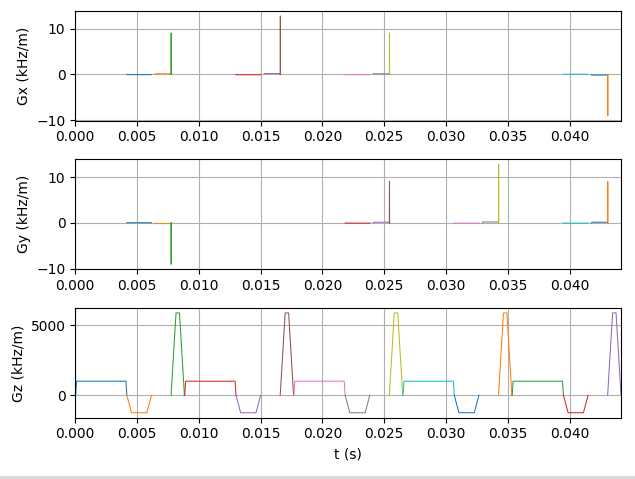


### Results

#### KomaMRI (Simulated)

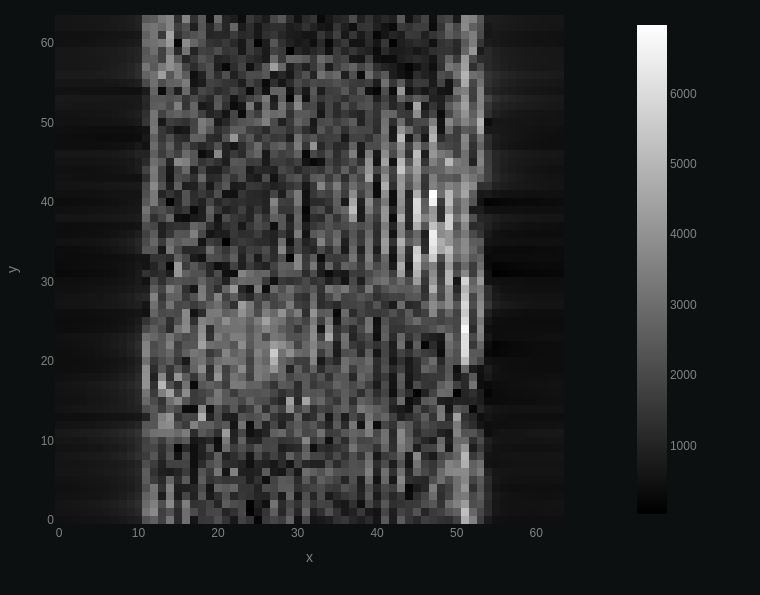

To put it simply this is an absolutely rubbish image, very sparse K-space coverage.

#### 3T MRI



## Radial, Total Time = 185ms
Variable changes:

- Flip Angle, Alpha = 90
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- Nr = 20
- N_dummy = 0

Hope that this improves signal/image quality.
**Note: Total time is too long for DIMAC**

FILENAME: gre_radial_185ms.py

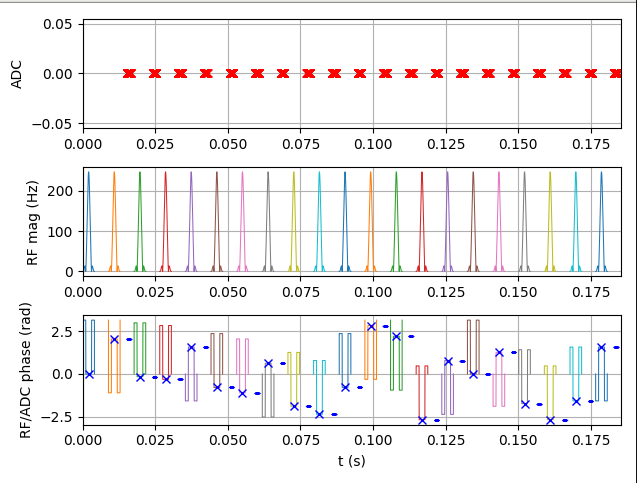
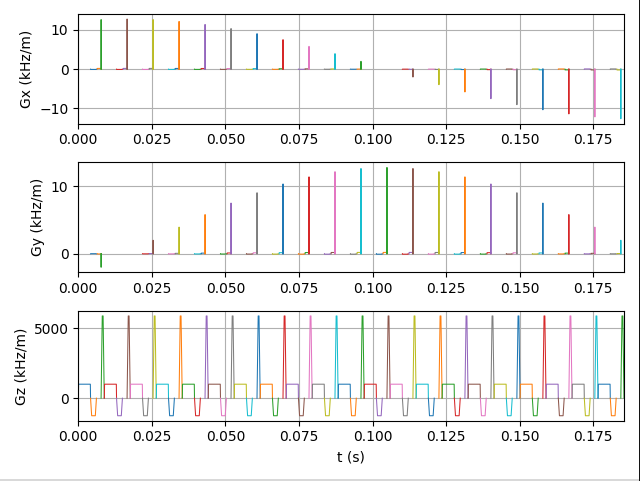


### Results
#### KomaMRI (Simulation)

KomaMRI seems to be struggling to make an image simulation, unsure whether this is because of the pulseq file or errors outside of this. I'm hoping that this is a problem with how KomaMRI deals with radial acquisitions.

As of 29/05/25, we have no KomaMRI image.

#### 3T MRI Result

# Golden Angle Radial

This type of K-space sampling uses the golden ratio/fibonnaci to try to quicken image acquisition time whilst retaining image quality. [source: Feng,L.(2022)](https://onlinelibrary.wiley.com/doi/full/10.1002/jmri.28187). 

*Trial: using fibbonacci numbers as spoke numbers and see if that does anything*

FILENAME for test environemnt: **write_radial_goldenangle_gre_rk.py**

## Half Spoke

EVERYTHING HERE IS INCORRECT THESE RESULTS ARE FOR FULL SPOKE!!!

**Angular increment, $\delta = 137.51^\circ$**
- alpha = $90^\circ$
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- N_dummy = 0

Note: Nr is the number of radial spokes. T is the total time for image acquisition.

### Nr = 5, T = 53ms 

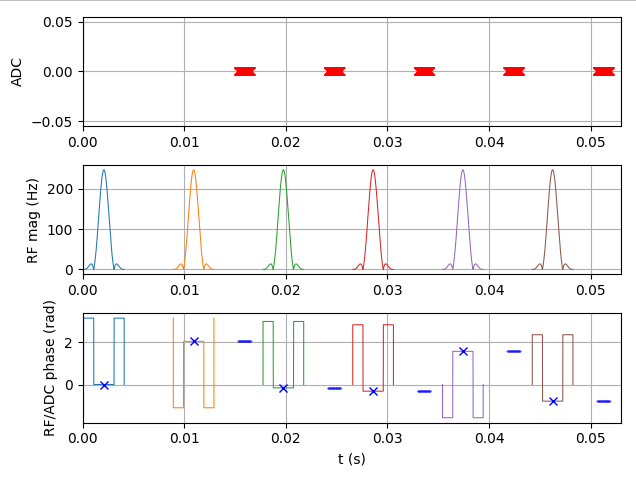
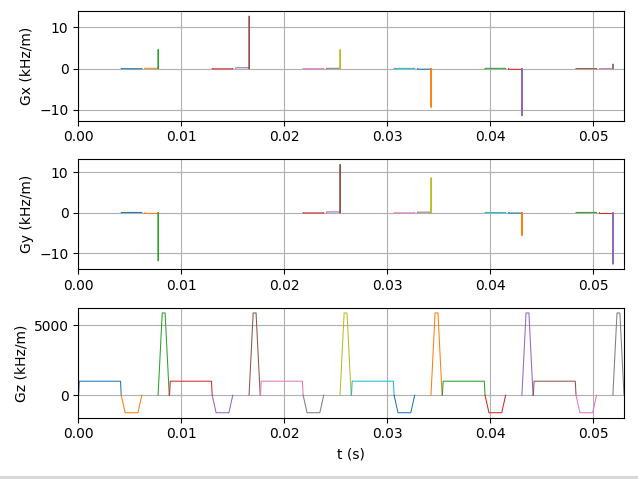



### Nr = 8



### Nr = 13 

### Nr = 20 

### Nr = 21 

## Full spoke

Angular increment, $\delta = 111.25^\circ$